In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import os
import pandas as pd
from scipy.spatial import ConvexHull
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import os
import sys
sys.path.append('/workspace/utils')
from utils3d_model import load_point_clouds, display_point_clouds
from optimization_utils import build_transformation_matrix, objective_function_rotation, transform_point_cloud_numpy

# Function to calculate volume of point cloud using convex hull
def calculate_volume(point_cloud):
    hull = ConvexHull(point_cloud)
    return hull.volume

def calculate_angular_error(rot1, rot2):
    norm_rot1, norm_rot2 = np.linalg.norm(rot1), np.linalg.norm(rot2)
    if norm_rot1 == 0 or norm_rot2 == 0:
        return 0
    cos_theta = np.clip(np.dot(rot1/norm_rot1, rot2/norm_rot2), -1.0, 1.0)
    return np.arccos(cos_theta) * (180 / np.pi)

def calculate_individual_angular_errors(rot1, rot2):
    # Convert rotations from radians to degrees
    rot1_degrees = np.degrees(rot1)
    rot2_degrees = np.degrees(rot2)

    # Calculate absolute error modulo 360 degrees
    yaw_error = np.abs(rot1_degrees[0] - rot2_degrees[0]) % 360
    pitch_error = np.abs(rot1_degrees[1] - rot2_degrees[1]) % 360
    roll_error = np.abs(rot1_degrees[2] - rot2_degrees[2]) % 360

    # Adjust for minimum angular difference
    yaw_error = min(yaw_error, 360 - yaw_error)
    pitch_error = min(pitch_error, 360 - pitch_error)
    roll_error = min(roll_error, 360 - roll_error)

    # Return the errors as a list of floats
    return [yaw_error, pitch_error, roll_error]

def optimize_alignment(initial_pc, reference_pc, actual_transformation, alpha, num_trials=10):
    best_loss = float('inf')
    best_transformation = None
    results_list = []

    for trial_number in range(num_trials):
        trial_loss_history, trial_angular_errors, trial_translational_errors = [], [], []

        def callback(xk):
            loss = objective_function_densityCD(xk, initial_pc, reference_pc, alpha)
            angular_error = calculate_individual_angular_errors(xk[:3], actual_transformation[:3])
            translational_error_vector = xk[3:] - actual_transformation[3:]  # Calculate vector differences
            trial_loss_history.append(loss)
            trial_angular_errors.append(angular_error)
            trial_translational_errors.append(translational_error_vector.tolist())  # Store component-wise errors

        initial_params = np.random.rand(6)  # 3 for rotation (radians), 3 for translation
        initial_params[:3] *= 2 * np.pi  # Scale rotation parameters
        res = minimize(objective_function_densityCD, initial_params, args=(initial_pc, reference_pc, alpha), callback=callback)

        if res.fun < best_loss:
            best_loss = res.fun
            best_transformation = res.x

        trial_data = {
            'Trial': trial_number + 1,
            'Best Transformation': best_transformation,
            'Initial Params': initial_params,
            'Loss History': trial_loss_history,
            'Angular Error History': trial_angular_errors,
            'Translational Error History': trial_translational_errors
        }
        results_list.append(trial_data)

    return results_list

def multiple_optimizations(initial_pc, reference_pc, actual_rotation, num_runs=50, num_trials=10):
    results_df = pd.DataFrame()

    for run in range(num_runs):
        data = optimize_alignment(initial_pc, reference_pc, actual_rotation, num_trials)
        # Add run number to each dictionary
        for d in data:
            d['Run'] = run + 1
        
        results_df = pd.concat([results_df, pd.DataFrame(data)], ignore_index=True)

    return results_df

def squared_euclidean_distance(x, y):
    return np.sum((x - y) ** 2)

def nearest_neighbor_distances_and_counts(set_from, set_to):
    distances = np.zeros(len(set_from))
    counts = np.zeros(len(set_from), dtype=int)
    for i, x in enumerate(set_from):
        dists = np.array([squared_euclidean_distance(x, y) for y in set_to])
        min_index = np.argmin(dists)
        distances[i] = dists[min_index]
        counts[i] = (dists == distances[i]).sum()
    return distances, counts

def objective_function_densityCD(params, initial_pc, reference_pc, alpha):
    # Convert parameters into a transformation matrix (assuming rotation + translation)
    rotation_matrix = params[:3]
    translation_vector = params[3:]

    # Apply transformation
    transformed_initial_pc = transform_point_cloud_numpy(initial_pc,build_transformation_matrix(rotation_matrix, translation_vector)) 

    # Compute distances and counts
    distances_S1_to_S2, counts_S2 = nearest_neighbor_distances_and_counts(transformed_initial_pc, reference_pc)
    distances_S2_to_S1, counts_S1 = nearest_neighbor_distances_and_counts(reference_pc, initial_pc)
    
    # Compute loss contributions
    term1 = 1 - (1 / counts_S2) * np.exp(-alpha * distances_S1_to_S2)
    term2 = 1 - (1 / counts_S1) * np.exp(-alpha * distances_S2_to_S1)
    
    # Calculate overall loss
    loss = 0.5 * (np.mean(term1) + np.mean(term2))
    return loss

def plot_angular_errors(df, run_number):
    df_run = df[df['Run'] == run_number]
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))
    titles = ['Yaw Error', 'Pitch Error', 'Roll Error']
    colors = ['r', 'g', 'b']

    for i, ax in enumerate(axes):
        for index, row in df_run.iterrows():
            angular_errors = row['Angular Error History']
            if isinstance(angular_errors, list) and all(isinstance(e, list) and len(e) == 3 for e in angular_errors):
                # Extract and plot each angular error component
                component_errors = [e[i] for e in angular_errors]
                ax.plot(component_errors, color=colors[i], label=f'Trial {row["Trial"]}')
            else:
                print(f"Data format issue at Run {row['Run']}, Trial {row['Trial']}")
            ax.set_title(titles[i])
            ax.set_xlabel('Iteration')
            ax.set_ylabel('Degrees')
            ax.legend()
            ax.grid(True)

    plt.tight_layout()
    plt.show()

def plot_histograms(best_losses, best_angular_errors):
    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.hist(best_losses, bins=20, edgecolor='black')
    plt.title('Histogram of Best Losses')
    plt.xlabel('Loss')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(best_angular_errors, bins=20, edgecolor='black')
    plt.title('Histogram of Best Angular Errors')
    plt.xlabel('Angular Error (degrees)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()



def plot_results(df, plot_type='Loss History', runs=None, trials=None, figsize=(10, 5), title=None, xlabel='Iteration', ylabel=None):
    """ General plotting for optimization metrics. """
    if runs is not None:
        df = df[df['Run'].isin(runs)]
    if trials is not None:
        df = df[df['Trial'].isin(trials)]

    plt.figure(figsize=figsize)
    if title is None:
        title = f'{plot_type} per Iteration'
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel if ylabel else plot_type)

    for (run, trial), group in df.groupby(['Run', 'Trial']):
        iterations = range(len(group.iloc[0][plot_type]))
        data = [item for sublist in group[plot_type].tolist() for item in sublist]  # Flatten if nested
        plt.plot(iterations, data, label=f'Run {run}, Trial {trial}')
        plt.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_best_results_per_run(df, plot_type='Loss History', runs=None, trials=None, figsize=(10, 5), title=None, xlabel='Run', ylabel=None):
    """ Plot the best value (minimum or maximum) of a specified metric for each run. """
    # Validate input DataFrame
    expected_columns = ['Run', 'Trial', plot_type]
    for col in expected_columns:
        if col not in df.columns:
            raise ValueError(f"DataFrame is missing expected column: {col}")

    # Filter DataFrame based on runs and trials if provided
    if runs is not None:
        df = df[df['Run'].isin(runs)]
    if trials is not None:
        df = df[df['Trial'].isin(trials)]

    plt.figure(figsize=figsize)
    if title is None:
        title = f'Best {plot_type} per Run'
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel if ylabel else plot_type)

    # Find and plot the best value per run
    best_values = []
    run_labels = []
    for run, group in df.groupby('Run'):
        # Flatten list if nested and find the minimum value
        flat_data = [item for sublist in group[plot_type].tolist() for item in sublist]
        best_value = min(flat_data)  # You can change this to max() if you're plotting a metric that should be maximized
        best_values.append(best_value)
        run_labels.append(run)

    plt.plot(run_labels, best_values, marker='o', linestyle='-', color='b')
    plt.grid(True)
    plt.xticks(run_labels)  # Ensure all run labels are shown
    plt.tight_layout()
    plt.show()


/workspace/utils/utils3d_model.py:93: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=0.5, c=colors[i-1])


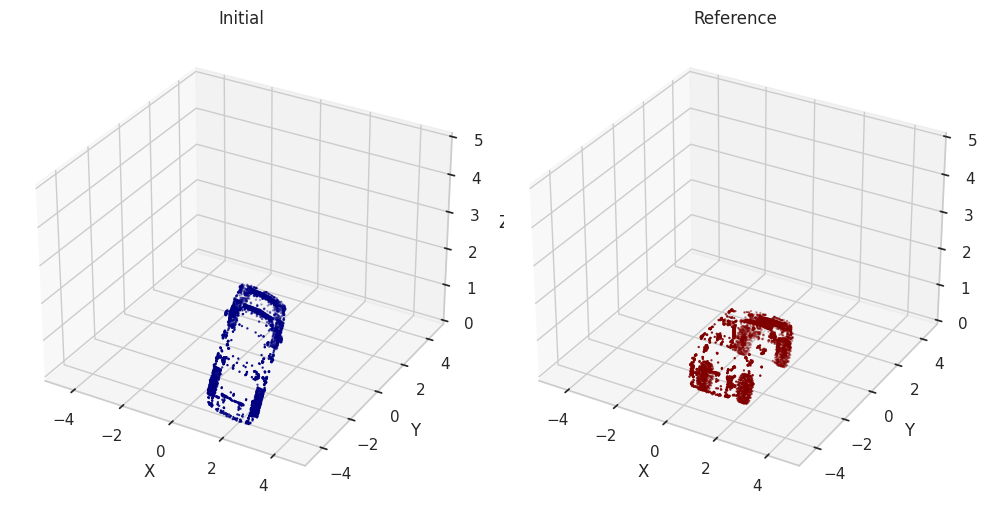

In [2]:
#set seed for reproducibility
np.random.seed(0)

# Main execution block
folder_path = '/workspace/datasets/apollo/car_models_json'
files = os.listdir(folder_path)

point_clouds, titles = load_point_clouds(folder_path, files, len(files))
initial_pc = point_clouds["SUV"][0]  # Assuming first point cloud as the initial
reference_pc = initial_pc.copy()

# Apply a random transformation to the reference point cloud
actual_rotation = np.random.rand(3) * 2 * np.pi

# Apply the transformation to the reference point cloud
initial_pc = transform_point_cloud_numpy(initial_pc, build_transformation_matrix(actual_rotation, np.zeros(3)))

display_point_clouds([initial_pc, reference_pc], ['Initial', 'Reference'])


In [3]:
# Perform multiple optimizations
num_runs = 10
num_trials = 10
df = multiple_optimizations(initial_pc, reference_pc,actual_rotation, num_runs, num_trials)

In [4]:
df.head()

,Run,Trial,Trial Best Transformation,Trial Initial Rotation,Loss History,Angular Error History
0,1,1,"[3.4482968783685632, 4.493667357774945, 3.7872...","[3.4236020095353483, 2.661901610522322, 4.0582...","[0.1237937703758652, 0.11927933491938567, 0.11...","[[24.769870630136637, 82.48215744951409, 48.68..."
1,1,2,"[3.4482968783685632, 4.493667357774945, 3.7872...","[2.749441536415439, 5.603175015853413, 6.05487...","[1.5518305658295588, 1.4724313723276607, 1.443...","[[117.85755719470512, 150.12743402386945, 128...."
2,1,3,"[3.448296984219335, 4.493667238745657, 3.78727...","[2.4092341172487513, 4.974555126607196, 3.3231...","[0.1069527805928856, 0.10414237896450602, 0.09...","[[51.034435261187724, 44.09970969164664, 15.17..."
3,1,4,"[3.448296984219335, 4.493667238745657, 3.78727...","[3.5691292400886723, 5.815695198095265, 0.4463...","[0.3543313550160301, 0.23761938599446497, 0.19...","[[4.088315224825607, 71.51652042614472, 170.08..."
4,1,5,"[3.448296984219335, 4.493667238745657, 3.78727...","[0.5474495357095673, 0.1270359377317719, 5.231...","[0.44914832325837417, 0.4487789789495573, 0.38...","[[163.747168039107, 110.69953624043157, 159.48..."


/tmp/ipykernel_28143/1991234196.py:179: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


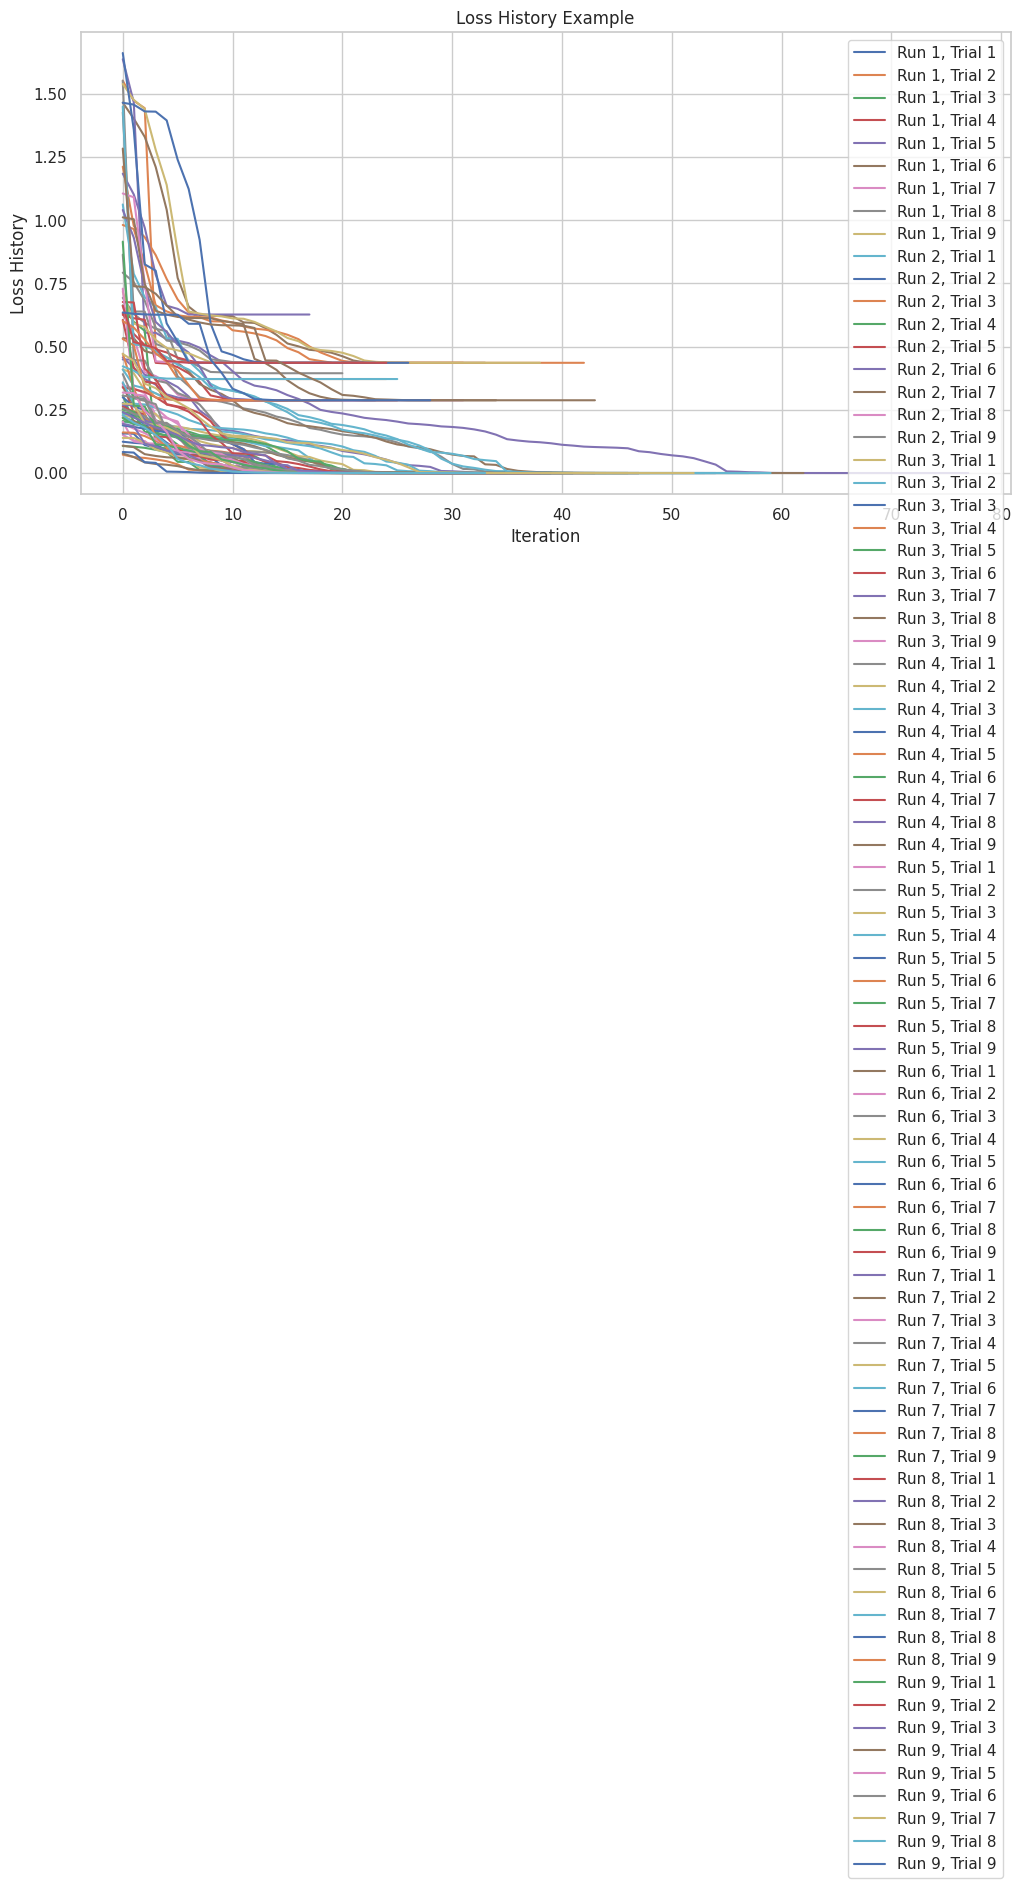

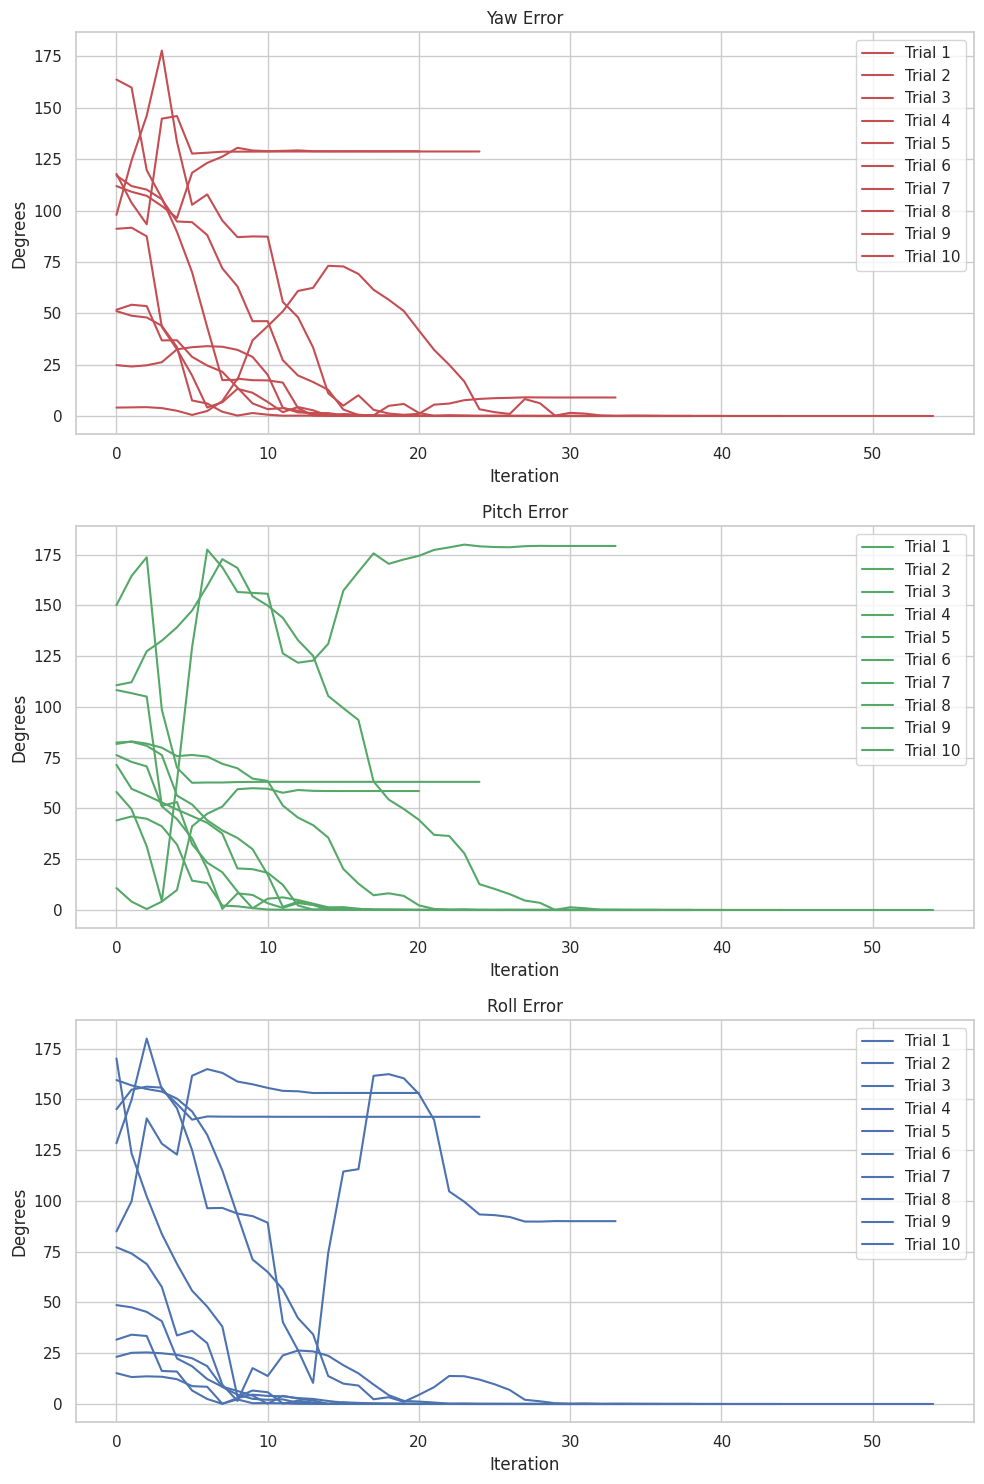

In [9]:
plot_results(df, plot_type='Loss History', runs=range(10), trials=range(10), figsize=(12, 6), title='Loss History Example')
plot_angular_errors(df, run_number=1)

/workspace/utils/utils3d_model.py:93: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=0.5, c=colors[i-1])


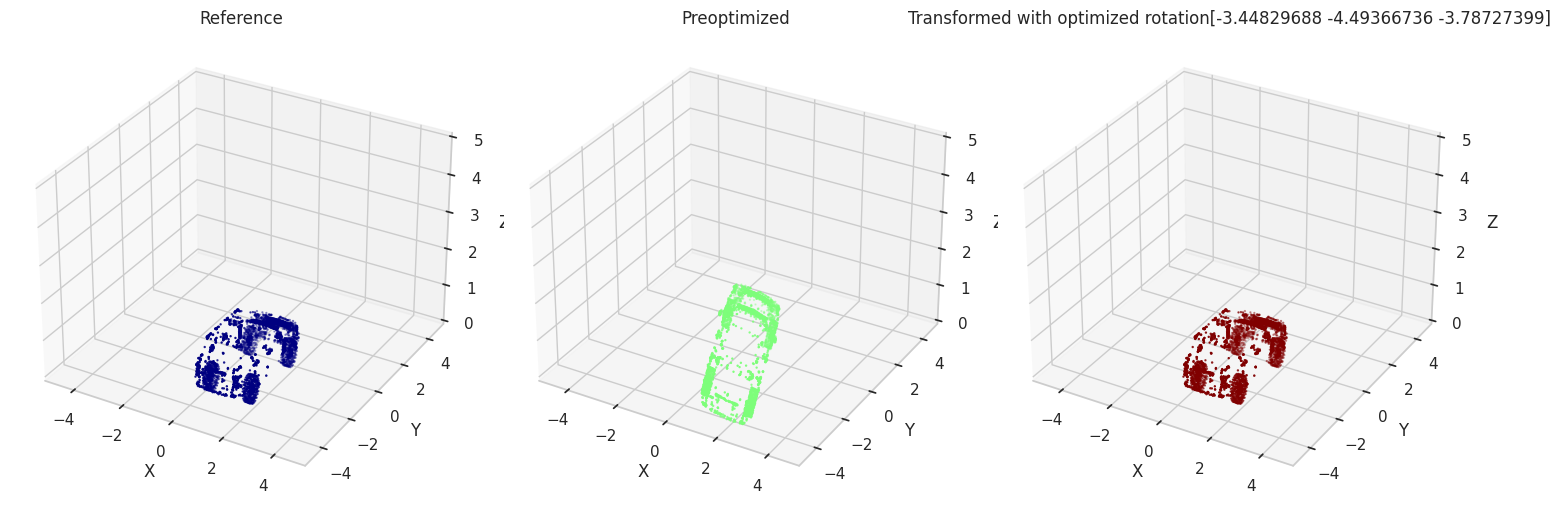

In [10]:
# show tranformed pc
transformed_pc = transform_point_cloud_numpy(initial_pc, build_transformation_matrix(-df['Trial Best Transformation'][0], np.zeros(3)))
display_point_clouds([reference_pc,initial_pc,transformed_pc], ['Reference', 'Preoptimized', 'Transformed with optimized rotation'+str(-df['Trial Best Transformation'][0])])

In [21]:
def get_best_final_loss_indexes(df, plot_type='Loss History'):
    """ Returns a DataFrame with the index of the trial with the best final loss for each run.

    Args:
        df (pd.DataFrame): DataFrame containing 'Run', 'Trial', and 'Loss History' columns.
        plot_type (str): The name of the column containing the loss history.

    Returns:
        pd.DataFrame: DataFrame containing 'Run' and 'Index of Best Final Loss'.
    """
    best_final_loss_indexes = []

    # Group by 'Run' to process each run individually
    for run, run_group in df.groupby('Run'):
        best_final_loss = float('inf')
        best_index = None

        # Loop through each trial in the run
        for index, trial_row in run_group.iterrows():
            final_loss = trial_row[plot_type][-1]  # Access the final loss of the trial
            if final_loss < best_final_loss:
                best_final_loss = final_loss
                best_index = index  # DataFrame index of the best trial

        # Append the best index and run number
        best_final_loss_indexes.append({'Run': run, 'Index of Best Final Loss': best_index})

    # Convert results to DataFrame
    return pd.DataFrame(best_final_loss_indexes)

best_final_loss_indexes = get_best_final_loss_indexes(df)
best_final_loss_indexes


,Run,Index of Best Final Loss
0,1,6
1,2,16
2,3,21
3,4,33
4,5,46
5,6,55
6,7,61
7,8,74
8,9,82
9,10,95


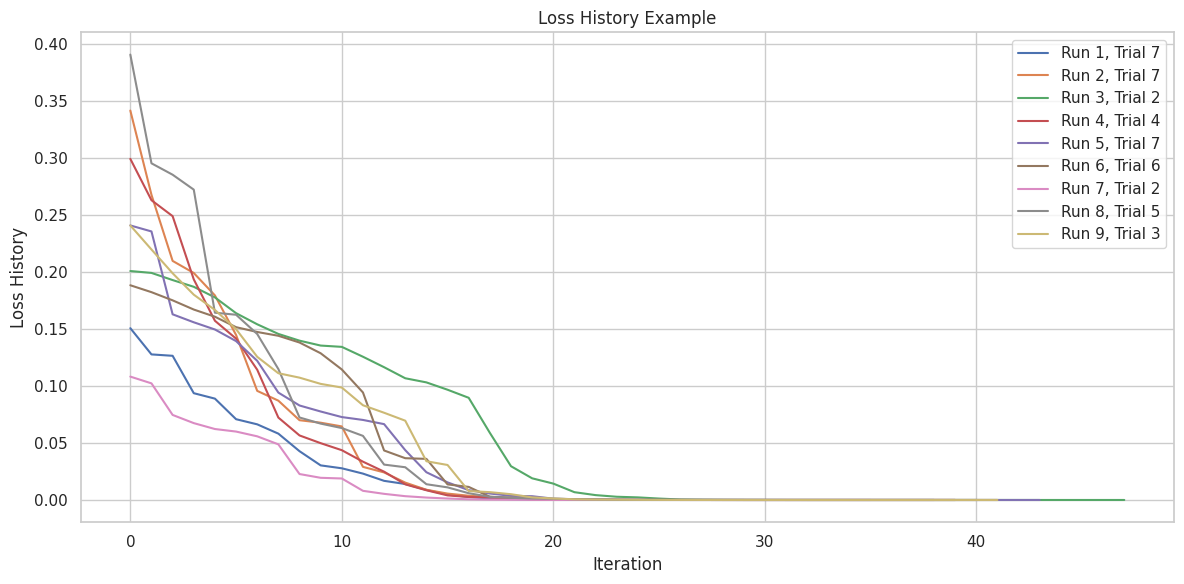

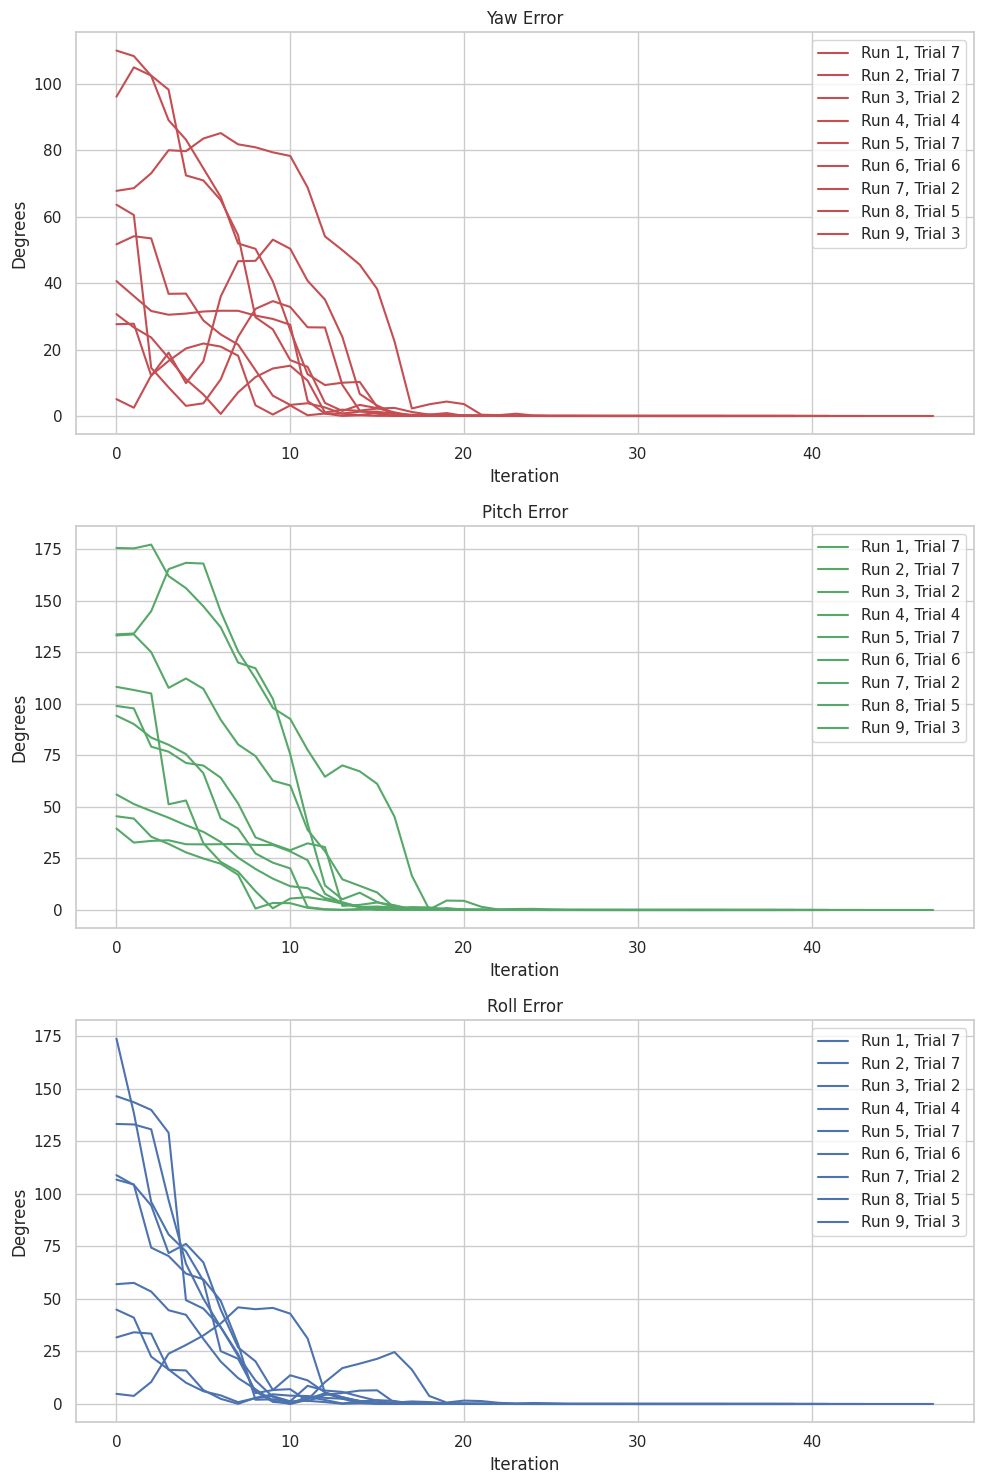

In [27]:
#get dataframe of those indexes
best_final_losses = df.loc[best_final_loss_indexes['Index of Best Final Loss']]

def plot_metrics(df, plot_type, runs=None, trials=None, figsize=(10, 5), 
                 subplot_config=None, title=None, xlabel='Iteration', ylabel=None):
    """
    General plotting function for different metrics, supporting single or multiple subplots.
    plot_type: Either 'Loss History' or 'Angular Error History' indicating which data to plot.
    subplot_config: None for single plot or a tuple (nrows, ncols) for subplot dimensions.
    """
    if runs is not None:
        df = df[df['Run'].isin(runs)]
    if trials is not None:
        df = df[df['Trial'].isin(trials)]

    if subplot_config is None:
        fig, ax = plt.subplots(figsize=figsize)
        axes = [ax]  # Use a single axis for plotting
    else:
        fig, axes = plt.subplots(subplot_config[0], subplot_config[1], figsize=figsize)
        axes = axes.flatten()  # Flatten in case of multi-dimensional axes array

    for (run, trial), group in df.groupby(['Run', 'Trial']):
        for idx, ax in enumerate(axes):
            if plot_type == 'Loss History':
                iterations = range(len(group.iloc[0][plot_type]))
                data = [item for sublist in group[plot_type].tolist() for item in sublist]  # Flatten if nested
                ax.plot(iterations, data, label=f'Run {run}, Trial {trial}')
            elif plot_type == 'Angular Error History':
                angular_errors = group.iloc[0][plot_type]
                if isinstance(angular_errors, list) and all(isinstance(e, list) and len(e) == 3 for e in angular_errors):
                    component_errors = [e[idx] for e in angular_errors]
                    ax.plot(component_errors, label=f'Run {run}, Trial {trial}')
                else:
                    print(f"Data format issue at Run {run}, Trial {trial}")

            ax.set_title(f'{["Yaw", "Pitch", "Roll"][idx]} Error' if plot_type == 'Angular Error History' else title or f'{plot_type} per Iteration')
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel if ylabel else plot_type)
            ax.legend()
            ax.grid(True)

    plt.tight_layout()
    plt.show()

def plot_angular_metrics(df, runs=None, trials=None, figsize=(10, 15)):
    """
    Plots yaw, pitch, and roll errors from a given DataFrame filtered by runs and trials.
    The function assumes the DataFrame has 'Run', 'Trial', and 'Angular Error History' columns.
    Each subplot will represent a different angular component: Yaw, Pitch, or Roll.
    """
    if runs is not None:
        df = df[df['Run'].isin(runs)]
    if trials is not None:
        df = df[df['Trial'].isin(trials)]

    # Define colors and titles for each type of angular error
    colors = {'Yaw': 'r', 'Pitch': 'g', 'Roll': 'b'}
    titles = ['Yaw Error', 'Pitch Error', 'Roll Error']

    # Create subplots
    fig, axes = plt.subplots(3, 1, figsize=figsize)

    for (run, trial), group in df.groupby(['Run', 'Trial']):
        angular_errors = group['Angular Error History'].tolist()[0]
        if all(isinstance(e, list) and len(e) == 3 for e in angular_errors):
            for i, ax in enumerate(axes):
                component_errors = [e[i] for e in angular_errors]
                ax.plot(component_errors, color=colors[titles[i].split()[0]], label=f'Run {run}, Trial {trial}')
                ax.set_title(titles[i])
                ax.set_xlabel('Iteration')
                ax.set_ylabel('Degrees')
                ax.legend()
                ax.grid(True)
        else:
            print(f"Data format issue at Run {run}, Trial {trial}")

    plt.tight_layout()
    plt.show()


plot_metrics(best_final_losses, plot_type='Loss History', runs=range(10), trials=range(10), figsize=(12, 6), title='Loss History Example')
plot_angular_metrics(best_final_losses, runs=range(10), trials=range(10), figsize=(10, 15))

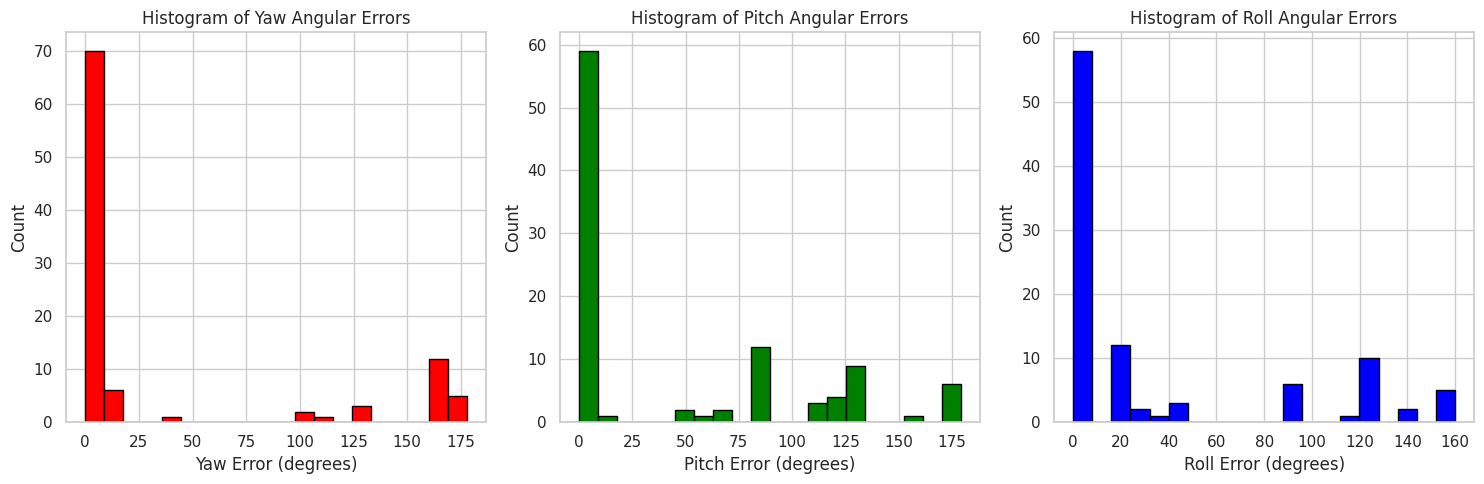

In [45]:
def plot_histograms_all_runs_angles(angular_errors):
    """
    Plots histograms for losses and angular errors (Yaw, Pitch, Roll) across all runs.
    'losses' is expected to be a list of all losses.
    'angular_errors' should be a dictionary with keys 'Yaw', 'Pitch', and 'Roll', each containing a list of angular errors.
    """
    # Setup figure and axes
    fig, axes = plt.subplots(1,3, figsize=(15, 5))
    axes = axes.flatten()  # Flatten the axes array for easier iteration

    # Define colors for different angular errors for visual clarity
    colors = {'Yaw': 'red', 'Pitch': 'green', 'Roll': 'blue'}


    # Histograms for angular errors
    for i, key in enumerate(['Yaw', 'Pitch', 'Roll'], start=0):
        component_errors = [e[i] for e in angular_errors]
        axes[i].hist(component_errors, bins=20, color=colors[key], edgecolor='black')
        axes[i].set_title(f'Histogram of {key} Angular Errors')
        axes[i].set_xlabel(f'{key} Error (degrees)')
        axes[i].set_ylabel('Count')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


# Extract final loss and angular errors for every index df
final_losses = df['Loss History'].apply(lambda x: x[-1]).tolist()
final_angular_errors = df['Angular Error History'].apply(lambda x: x[-1]).tolist()

# Plot histograms for losses and angular errors
plot_histograms_all_runs_angles(final_angular_errors)


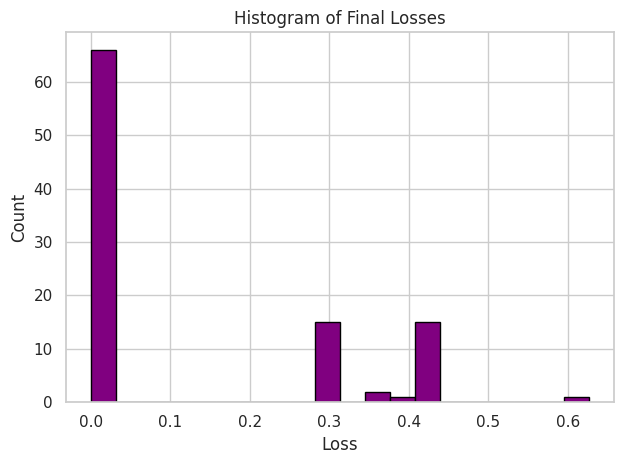

In [49]:
def plot_histograms_all_runs_losses(losses):
    """
    Plots histograms for losses and angular errors (Yaw, Pitch, Roll) across all runs.
    'losses' is expected to be a list of all losses.
    'angular_errors' should be a dictionary with keys 'Yaw', 'Pitch', and 'Roll', each containing a list of angular errors.
    """

    # Histograms for angular errors
    plt.hist(losses, bins=20, color='purple', edgecolor='black')
    plt.title('Histogram of Final Losses')
    plt.xlabel('Loss')
    plt.ylabel('Count')
    
    

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

plot_histograms_all_runs_losses(final_losses)